In [ ]:
import requests
import io
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from statistics import mean
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from IPython.display import clear_output
response = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/00310/UJIndoorLoc.zip')
compressedFile = io.BytesIO(response.content)
zipFile = ZipFile(compressedFile)

# LOAD DATASET
trainingData = pd.read_csv(zipFile.open('UJIndoorLoc/trainingData.csv'))
trainingData = trainingData.replace(100, np.nan)
validationData = pd.read_csv(zipFile.open('UJIndoorLoc/validationData.csv'))
validationData = validationData.replace(100, np.nan)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


DESCRIBE AND VISUALIZE THE DATASET

In [ ]:
# view a sample of the training dataframe 
trainingData.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,WAP013,WAP014,WAP015,WAP016,WAP017,WAP018,WAP019,WAP020,WAP021,WAP022,WAP023,WAP024,WAP025,WAP026,WAP027,WAP028,WAP029,WAP030,WAP031,WAP032,WAP033,WAP034,WAP035,WAP036,WAP037,WAP038,WAP039,WAP040,...,WAP490,WAP491,WAP492,WAP493,WAP494,WAP495,WAP496,WAP497,WAP498,WAP499,WAP500,WAP501,WAP502,WAP503,WAP504,WAP505,WAP506,WAP507,WAP508,WAP509,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-97.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-92.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [ ]:
# understand the makeup of the Training data
trainingData.describe()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,WAP013,WAP014,WAP015,WAP016,WAP017,WAP018,WAP019,WAP020,WAP021,WAP022,WAP023,WAP024,WAP025,WAP026,WAP027,WAP028,WAP029,WAP030,WAP031,WAP032,WAP033,WAP034,WAP035,WAP036,WAP037,WAP038,WAP039,WAP040,...,WAP490,WAP491,WAP492,WAP493,WAP494,WAP495,WAP496,WAP497,WAP498,WAP499,WAP500,WAP501,WAP502,WAP503,WAP504,WAP505,WAP506,WAP507,WAP508,WAP509,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,18.000000,19.000000,0.0,0.0,40.000000,308.000000,578.000000,677.000000,595.000000,87.000000,2956.000000,2983.00000,1975.000000,1955.000000,1007.000000,999.000000,84.000000,89.000000,418.000000,390.000000,37.000000,37.000000,781.000000,786.000000,631.000000,655.000000,781.000000,811.000000,1524.000000,1576.000000,609.000000,609.000000,1566.000000,1561.000000,1880.000000,1878.000000,864.000000,711.000000,1505.000000,1537.000000,...,12.000000,0.0,115.000000,119.000000,98.000000,3140.000000,4750.000000,0.0,120.000000,127.000000,104.000000,3359.000000,4637.000000,1822.000000,67.000000,2.0,31.000000,2.000000,92.000000,6.000000,1.0,1653.000000,14.000000,123.000000,126.000000,60.000000,3038.000000,4543.000000,22.000000,3.000000,0.0,19937.000000,1.993700e+04,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,19937.000000,1.993700e+04
mean,-95.333333,-87.894737,NaN,NaN,-92.525000,-85.746753,-81.652249,-81.988183,-77.793277,-91.632184,-74.383965,-74.44586,-73.672911,-73.779540,-85.765641,-87.055055,-89.880952,-89.292135,-75.210526,-74.976923,-94.216216,-93.945946,-77.563380,-77.564885,-77.768621,-77.929771,-77.591549,-77.362515,-72.291339,-72.924492,-74.238095,-73.929392,-72.361430,-72.264574,-72.887766,-73.095314,-79.508102,-79.330520,-71.728904,-72.115810,...,-92.083333,NaN,-80.852174,-84.428571,-87.265306,-73.156369,-76.304211,NaN,-81.183333,-84.889764,-87.903846,-72.970527,-76.423981,-81.347969,-88.671642,-85.0,-89.709677,-96.000000,-91.717391,-88.166667,-97.0,-81.218996,-89.571429,-81.333333,-84.603175,-87.233333,-72.557604,-76.023993,-91.545455,-96.000000,NaN,-7464.275947,4.864871e+06,1.674575,1.212820,148.429954,1.833024,9.068014,13.021869,1.371421e+09
std,1.137593,2.051957,NaN,NaN,2.148195,8.343256,11.486342,9.680083,10.239520,3.760613,13.299303,13.41112,11.237482,11.287668,6.822129,5.993314,3.863343,3.855935,9.707654,9.886865,2.056631,2.040506,13.939802,13.830604,10.808743,10.422187,11.592587,11.161078,13.905049,13.875364,14.237095,13.754901,12.963735,12.906412,13.684954,13.581851,12.816014,13.157621,13.335667,13.119081,...,2.810963,NaN,5.276967,4.925842,3.665248,13.946882,11.921441,NaN,5.412378,4.995599,4.350023,14.166058,11.316191,9.597255,3.504923,0.0,3.653250,1.414214,1.749889,4.915960,NaN,12.427483,5.258170,5.580509,4.897476,4.533740,14.605846,12.056910,3.725425,1.732051,NaN,123.402010,6.693318e+01,1.223078,0.833139,58.342106,0.372964,4.988720,5.362410,5.572054e+05
min,-97.000000,-90.000000,NaN,NaN,-97.000000,-98.000000,-99.000000,-98.000000,-98.000000,-99.000000,-101.000000,-101.00000,-98.000000,-98.000000,-101.000000,-99.000000,-98.000000,-98.000000,-99.000000,-99.000000,-98.000000,-98.000000,-100.000000,-99.000000,-98.000000,-98.000000,-99.000000,-98.000000,-98.000000,-99.000000,-99.000000,-101.000000,-98.000000,-98.000000,-100.000000,-98.000000,-99.000000,-98.000000,-100.000000,-98.000000,...,-96.000000,NaN,-90.000000,-91.000000,-97.000000,-100.000000,-101.000000,NaN,-90.000000,-91.000000,-97.000000,-101.000000,-97.000000,-102.000000,-99.000000,-85.0,-97.000000,-97.000000,-97.000000,-98.000000,-97.0,-103.000000,-97.000000,-92.000000,-90.000000,-97.000000,-101.000000,-101.000000,-97.000000,-97.000000,NaN,-7691.338400,4.864746e+06,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.369909e+09
25%,-96.000000,-90.000000,NaN,NaN,-94.000000,-91.000000,-91.000000,-88.000000,-87.000000,-95.000000,-85.000000,-85.00000,-83.000000

In [ ]:
# understand the makeup of the Training data
trainingData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19937 entries, 0 to 19936
Columns: 529 entries, WAP001 to TIMESTAMP
dtypes: float64(522), int64(7)
memory usage: 80.5 MB


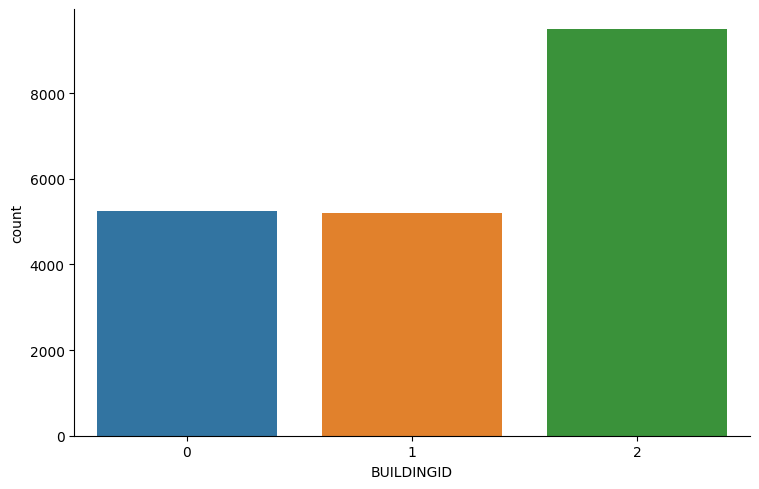

In [ ]:
# Use seaborn to plot the Buildings
fg = sns.catplot('BUILDINGID', data=trainingData, kind='count', aspect=1.5)
plt.style.use('default')
fg.set_xlabels('BUILDINGID')
plt.show()

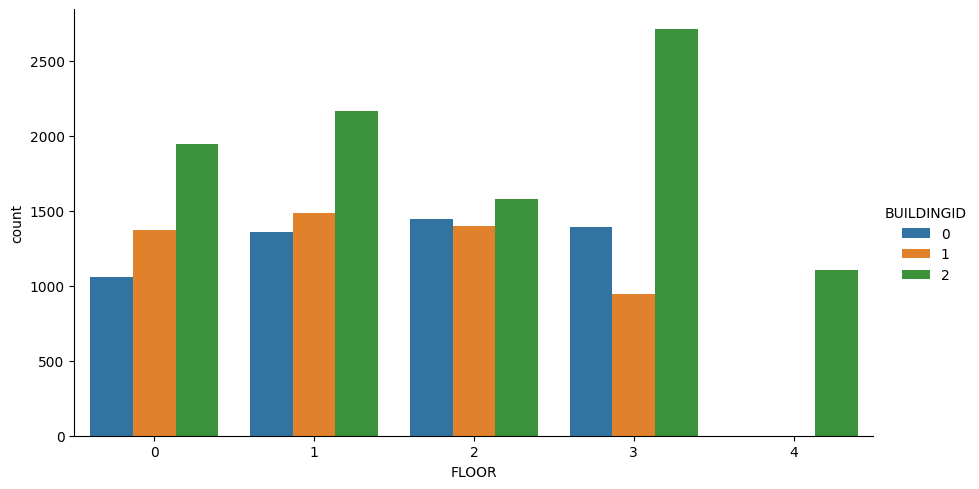

In [ ]:
# Again use saeborn to group by FLOOR and BUILDING
fg = sns.catplot('FLOOR', data=trainingData, hue='BUILDINGID', kind='count', aspect=1.75)
plt.style.use('default')
fg.set_xlabels('FLOOR')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


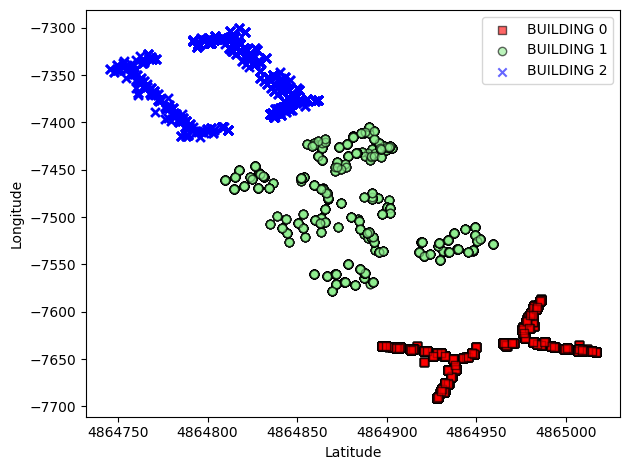

In [ ]:
# plot the reference points

xTrain = trainingData.iloc[:,:520]
xTest = validationData.iloc[:,:520]
yTrain = trainingData.iloc[:,520:526]
yTest = validationData.iloc[:,520:526]

markers = ('s', 'o', 'x', '^', 'v')
colors = ('red', 'lightgreen', 'blue', 'gray', 'cyan')
from matplotlib.colors import ListedColormap
cmap = ListedColormap(colors[:len(np.unique(yTrain['BUILDINGID']))])

for idx, cl in enumerate(np.unique(yTrain['BUILDINGID'])):
        plt.scatter(x=yTrain.loc[yTrain.BUILDINGID== cl]['LATITUDE'], 
                    y=yTrain.loc[yTrain.BUILDINGID== cl]['LONGITUDE'],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label='BUILDING ' + str(cl))

plt.style.use('default')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.ticklabel_format(style='plain')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


EXPLORATORY DATA ANALYSIS (EDA)

In [ ]:
# check the presence of duplicate rows

print("Number of duplicate rows:", trainingData.duplicated(subset=None, keep='first').sum())

# remove duplicate rows
# trainingData.drop_duplicates(subset=None, keep='first', inplace=True)

# check the presence of duplicate columns

print("Number of duplicate columns:", trainingData.columns.duplicated().sum())

Number of duplicate rows: 637
Number of duplicate columns: 0


In [ ]:
# check the presence of null rows (null scans with no WiFi coverage)

print("Number of null rows:", xTrain.isnull().all(axis=1).sum())

# remove null rows
# trainingData.iloc[~xTrain.isnull().all(axis=1).values]

# check the presence of null rows (APs never detected)

print("Number of null columns:", xTrain.isnull().all(axis=0).sum())
 
# remove null columns
# validationData.iloc[:,np.append(~xTrain.isnull().all(axis=0).values, np.full(9, True))]

Number of null rows: 76
Number of null columns: 55


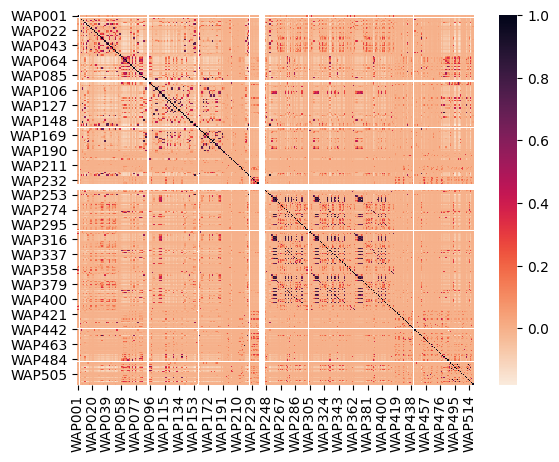

In [ ]:
# correlation matrix

trainingCorrelationMatrix = xTrain.fillna(-110).corr()
sns.heatmap(trainingCorrelationMatrix, cmap = sns.cm.rocket_r)
plt.show()

Study of the dataset

In [ ]:
# STUDY OF THE TRAINING DATASET
trainingData = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/trainingData.csv")
# build a complete label
trainingData = trainingData.assign(LABEL = 'B' + trainingData.BUILDINGID.astype(str) + 'F' + trainingData.FLOOR.astype(str) + 'R' + trainingData.SPACEID.astype(str))
# number and list of buildings
buildings = np.unique(trainingData.BUILDINGID)
numberBuildings = np.unique(trainingData.BUILDINGID).shape[0]
# number and list of floors
floors = np.unique(trainingData.FLOOR)
numberFloors = np.unique(trainingData.FLOOR).shape[0]
# number and list of rooms
rooms = np.unique(trainingData.SPACEID)
numberRooms = np.unique(trainingData.SPACEID).shape[0]
# label buildingID + floorID
BFLabels = np.unique([trainingData.LABEL[i][:4] for i in range(trainingData.shape[0])])
# number of scans for floor
numberScansForFloor = [(floorId, sum([trainingData.LABEL[row][:4] == floorId for row in range(trainingData.shape[0])])) for floorId in BFLabels]
# number of rooms for floor
numberRoomsForFloor = [(floorId, np.unique(trainingData[[trainingData.LABEL[row][:4] == floorId for row in range(trainingData.shape[0])]].SPACEID).shape[0]) for floorId in BFLabels]
# rooms for each floor
roomsForFloor = []
for buildingAndFloor in BFLabels:
  rooms = []
  for label in trainingData.LABEL:
    if label.split("R")[0] == buildingAndFloor:
      rooms.append(label.split("R")[1])
  roomsForFloor.append(("Floor:", buildingAndFloor, "Rooms:", np.unique(np.array(rooms))))
trainingData

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,WAP013,WAP014,WAP015,WAP016,WAP017,WAP018,WAP019,WAP020,WAP021,WAP022,WAP023,WAP024,WAP025,WAP026,WAP027,WAP028,WAP029,WAP030,WAP031,WAP032,WAP033,WAP034,WAP035,WAP036,WAP037,WAP038,WAP039,WAP040,...,WAP491,WAP492,WAP493,WAP494,WAP495,WAP496,WAP497,WAP498,WAP499,WAP500,WAP501,WAP502,WAP503,WAP504,WAP505,WAP506,WAP507,WAP508,WAP509,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,LABEL
0,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733,B1F2R106
1,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691,B1F2R106
2,100,100,100,100,100,100,100,-97,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095,B1F2R103
3,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-92,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807,B1F2R102
4,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710,B0F0R122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19932,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-75,-76,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-92,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7485.4686,4.864875e+06,3,1,1,2,18,10,1371710683,B1F3R1
19933,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,-91,100,100,100,100,100,-89,-73,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7390.6206,4.864836e+06,1,2,140,2,18,10,1371710402,B2F1R140
19934,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-95,-94,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7516.8415,4.864889e+06,3,1,13,2,18,10,1371710921,B1F3R13
19935,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-91,-92,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7537.3219,4.864896e+06,3

In [ ]:
# STUDY OF THE VALIDATION DATASET
validationData = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/validationData.csv")
# build a complete label
validationData = validationData.assign(LABEL = 'B' + validationData.BUILDINGID.astype(str) + 'F' + validationData.FLOOR.astype(str) + 'R' + validationData.SPACEID.astype(str))
# number and list of buildings
buildings = np.unique(validationData.BUILDINGID)
numberBuildings = np.unique(validationData.BUILDINGID).shape[0]
# number and list of floors
floors = np.unique(validationData.FLOOR)
numberFloors = np.unique(validationData.FLOOR).shape[0]
# number and list of rooms
rooms = np.unique(validationData.SPACEID)
numberRooms = np.unique(validationData.SPACEID).shape[0]
# label buildingID + floorID
BFLabels = np.unique([validationData.LABEL[i][:4] for i in range(validationData.shape[0])])
# number of scans for floor
numberScansForFloor = [(floorId, sum([validationData.LABEL[row][:4] == floorId for row in range(validationData.shape[0])])) for floorId in BFLabels]
# number of rooms for floor
numberRoomsForFloor = [(floorId, np.unique(validationData[[validationData.LABEL[row][:4] == floorId for row in range(validationData.shape[0])]].SPACEID).shape[0]) for floorId in BFLabels]
# rooms for each floor
roomsForFloor = []
for buildingAndFloor in BFLabels:
  rooms = []
  for label in validationData.LABEL:
    if label.split("R")[0] == buildingAndFloor:
      rooms.append(label.split("R")[1])
  roomsForFloor.append(("Floor:", buildingAndFloor, "Rooms:", np.unique(np.array(rooms))))
validationData

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,WAP013,WAP014,WAP015,WAP016,WAP017,WAP018,WAP019,WAP020,WAP021,WAP022,WAP023,WAP024,WAP025,WAP026,WAP027,WAP028,WAP029,WAP030,WAP031,WAP032,WAP033,WAP034,WAP035,WAP036,WAP037,WAP038,WAP039,WAP040,...,WAP491,WAP492,WAP493,WAP494,WAP495,WAP496,WAP497,WAP498,WAP499,WAP500,WAP501,WAP502,WAP503,WAP504,WAP505,WAP506,WAP507,WAP508,WAP509,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,LABEL
0,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-91,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7515.916799,4.864890e+06,1,1,0,0,0,0,1380872703,B1F1R0
1,100,100,100,100,100,100,100,100,100,100,-87,-87,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7383.867221,4.864840e+06,4,2,0,0,0,13,1381155054,B2F4R0
2,100,100,100,100,100,100,100,100,100,100,-73,-72,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7374.302080,4.864847e+06,4,2,0,0,0,13,1381155095,B2F4R0
3,100,100,100,100,100,100,100,100,100,100,-77,-75,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7365.824883,4.864843e+06,4,2,0,0,0,13,1381155138,B2F4R0
4,100,100,100,100,100,100,100,100,100,100,100,100,-79,-79,100,100,100,100,100,100,100,100,-83,-78,100,100,100,100,-62,-62,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7641.499303,4.864922e+06,2,0,0,0,0,2,1380877774,B0F2R0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7317.344231,4.864796e+06,3,2,0,0,0,13,1381156711,B2F3R0
1107,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7313.731120,4.864792e+06,3,2,0,0,0,13,1381156730,B2F3R0
1108,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-76,-77,100,100,100,100,-94,100,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7637.535798,4.864903e+06,0,0,0,0,0,13,1381247781,B0F0R0
1109,100,100,100,100,100,100,100,100,100,100,100,100,100,-97,100,100,100,100,100,100,100,100,-84,-84,100,100,100,100,100,-97,100,100,100,100,100,100,100,100,100,100,...,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,-7636.654005,4.864905e+06,0,0,0,0,0,13,138124

In [ ]:
# STUDY OF THE COMMON SMARTPHONES BETWEEN TRAIN AND VALIDATION AND NUMBER OF SCANS
trainingData = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/trainingData.csv")
validationData = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/validationData.csv")
A = np.unique(trainingData['PHONEID'])
B = np.unique(validationData['PHONEID'])
print("Common smartphones between training and validation:", np.intersect1d(A,B))
print("Training data = 13:",sum(trainingData['PHONEID']==13), "Training data = 14:",sum(trainingData['PHONEID']==14))
print("Validation data = 13:",sum(validationData['PHONEID']==13), "Validation data = 14:",sum(validationData['PHONEID']==14))

Common smartphones between training and validation: [13 14]
Training data = 13: 4516 Training data = 14: 4835
Validation data = 13: 369 Validation data = 14: 28


APPLYING THE ALGORITHM ON THE TRAINING DATASET FILTERED BY SMARTPHONE 13 AND TESTING IT ON THE VALIDATION SET FILTERED BY SMARTHPONE 13

The validation set does not contain information about the room, hence the room accuracy is 0%



In [ ]:
# PREPARE THE TRAINING DATASET
trainingData = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/trainingData.csv")
# choose the phone model 13 (HTC Wildfire S 2.3.5) by user 11
trainingData = trainingData.loc[trainingData['PHONEID']==13]
# creating a label column of the format BUILDING FLOOR ROOM
trainingData = trainingData.assign(LABEL = 'B' + trainingData.BUILDINGID.astype(str) + 'F' + trainingData.FLOOR.astype(str) + 'R' + trainingData.SPACEID.astype(str))
# dropping useless columns
trainingData = trainingData.drop(['LONGITUDE','LATITUDE','USERID','PHONEID','TIMESTAMP','RELATIVEPOSITION','FLOOR','BUILDINGID','SPACEID'],axis=1)
# reset index
trainingData = trainingData.reset_index().drop('index',axis=1)
# setting non-detected APs to -150 dBm
trainingData = trainingData.replace(to_replace=100,value=-150)
# TRAINING PHASE
xTrain = trainingData.drop('LABEL',axis=1)
yTrain = trainingData['LABEL']
# yTrain.shape[0] / np.unique(yTrain).shape[0] average number of scans per room
neigh = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute', p=1, metric='minkowski')
neigh.fit(xTrain,yTrain)
# PREPARE THE TEST SET
validationData = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/validationData.csv")
validationData = validationData.loc[validationData['PHONEID']==13]
validationData = validationData.assign(LABEL = 'B' + validationData.BUILDINGID.astype(str) + 'F' + validationData.FLOOR.astype(str) + 'R' + validationData.SPACEID.astype(str))
validationData = validationData.drop(['LONGITUDE','LATITUDE','USERID','PHONEID','TIMESTAMP','RELATIVEPOSITION','FLOOR','BUILDINGID','SPACEID'],axis=1)
validationData = validationData.reset_index().drop('index',axis=1)
validationData = validationData.replace(to_replace=100,value=-150)
# TEST PHASE
xTest = validationData.drop('LABEL',axis=1)
yTest = validationData['LABEL']
yPred = neigh.predict(xTest)
print("Room accuracy:",accuracy_score(yTest,yPred))
yTest = [yTest[i][:4] for i in range(yTest.shape[0])]
yPred = [yPred[i][:4] for i in range(yPred.shape[0])]
print("Floor accuracy:",accuracy_score(yTest,yPred))
yTest = [yTest[i][:2] for i in range(len(yTest))]
yPred = [yPred[i][:2] for i in range(len(yPred))]
print("Building accuracy:",accuracy_score(yTest,yPred))




Room accuracy: 0.0
Floor accuracy: 0.6314363143631436
Building accuracy: 0.8292682926829268


USING THE TRAINING DATASET AS BOTH TRAINING AND VALIDATION DATASET, FILTERING BY ONE SMARTPHONE AT TIME

Compute the size of the training dataset when filtered by one smartphone

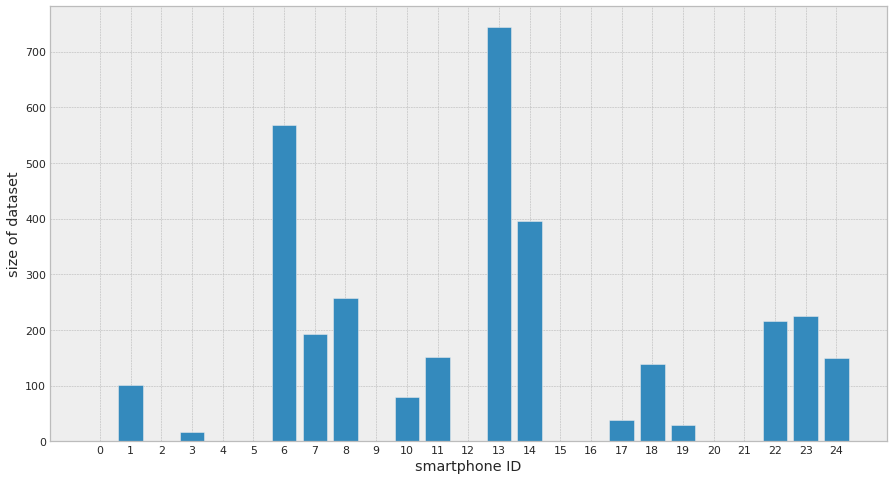

In [ ]:
trainingData = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/trainingData.csv")
#np.unique(trainingData['PHONEID'])
numberScans = []
for phoneID in range(25):
  # filter by the phone number
  dataset = trainingData.loc[trainingData['PHONEID']==phoneID]
  # filter by the relative position (drop the scans outside the room)
  dataset = dataset.loc[trainingData['RELATIVEPOSITION']==1]
  # drop scans with no APs detected
  dataset = dataset.loc[dataset.iloc[:,:520].ne(100,axis=0).any(axis=1)].reset_index().drop('index',axis=1)
  numberScans.append(dataset.shape[0])
# bar plot
plt.figure(figsize=[15, 8])
plt.style.use('bmh')
#plt.grid(zorder=0)
plt.bar(range(25), numberScans, align='center')
plt.xticks(range(25))
plt.xlabel("smartphone ID")
plt.ylabel("size of dataset")
plt.show()

In [ ]:
fullDataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/trainingData.csv")
# create a label column of the format BUILDING FLOOR ROOM
fullDataset = fullDataset.assign(LABEL = 'B' + fullDataset.BUILDINGID.astype(str) + 'F' + fullDataset.FLOOR.astype(str) + 'R' + fullDataset.SPACEID.astype(str))
# drop scans with no APs detected
fullDataset = fullDataset.loc[fullDataset.iloc[:,:520].ne(100,axis=0).any(axis=1)].reset_index().drop('index',axis=1)
# drop APs never detected
fullDataset = fullDataset.iloc[:, fullDataset.iloc[:,:520].ne(100,axis=1).any(axis=0).values.tolist() + [True]*10]
# filter by the relative position (drop the scans outside the room)
fullDataset = fullDataset.loc[fullDataset['RELATIVEPOSITION']==1].reset_index().drop('index',axis=1)
# set the non-detected APs to -150 dBm
fullDataset = fullDataset.replace(to_replace=100,value=-150)
results = []
for iterationNumber in range(100):
  clear_output(wait=True) # clear output for each iteration
  for phoneID in range(25):
    #print(phoneID)
    # filter by the phone number
    dataset = fullDataset.loc[fullDataset['PHONEID']==phoneID]
    # drop useless columns
    dataset = dataset.drop(['LONGITUDE','LATITUDE','USERID','PHONEID','TIMESTAMP','RELATIVEPOSITION','FLOOR','BUILDINGID','SPACEID'],axis=1)
    # split the training and test set
    data = dataset.drop('LABEL',axis=1)
    labels = dataset['LABEL']
    try:
      xTrain, xTest, yTrain, yTest = train_test_split(data,labels,test_size=0.25,stratify=labels)
      # training phase
      neigh = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute', p=1, metric='minkowski')
      neigh.fit(xTrain,yTrain)
      # validation phase
      yPred = neigh.predict(xTest)
      # accuracy evaluation
      #print("Room accuracy:",accuracy_score(yTest,yPred))
      roomAccuracy = (phoneID, "roomAccuracy", accuracy_score(yTest,yPred))
      yTest = [yTest.reset_index().LABEL[i][:4] for i in range(yTest.shape[0])]
      yPred = [yPred[i][:4] for i in range(yPred.shape[0])]
      #print("Floor accuracy:",accuracy_score(yTest,yPred))
      floorAccuracy = (phoneID, "floorAccuracy", accuracy_score(yTest,yPred))
      yTest = [yTest[i][:2] for i in range(len(yTest))]
      yPred = [yPred[i][:2] for i in range(len(yPred))]
      #print("Building accuracy:",accuracy_score(yTest,yPred))
      buildingAccuracy = (phoneID, "buildingAccuracy", accuracy_score(yTest,yPred))
      accuracy = (roomAccuracy, floorAccuracy, buildingAccuracy)
      results.append(accuracy)
    except:
      #print("Error")
      roomAccuracy = (phoneID, "roomAccuracy", 0)
      floorAccuracy = (phoneID, "floorAccuracy", 0)
      buildingAccuracy = (phoneID, "buildingAccuracy", 0)
      accuracy = (roomAccuracy, floorAccuracy, buildingAccuracy)
      results.append(accuracy)
  print("Progess:",np.round((iterationNumber+1)/len(range(100)) *100, 2),"%") # print loop progress


Progess: 100.0 %


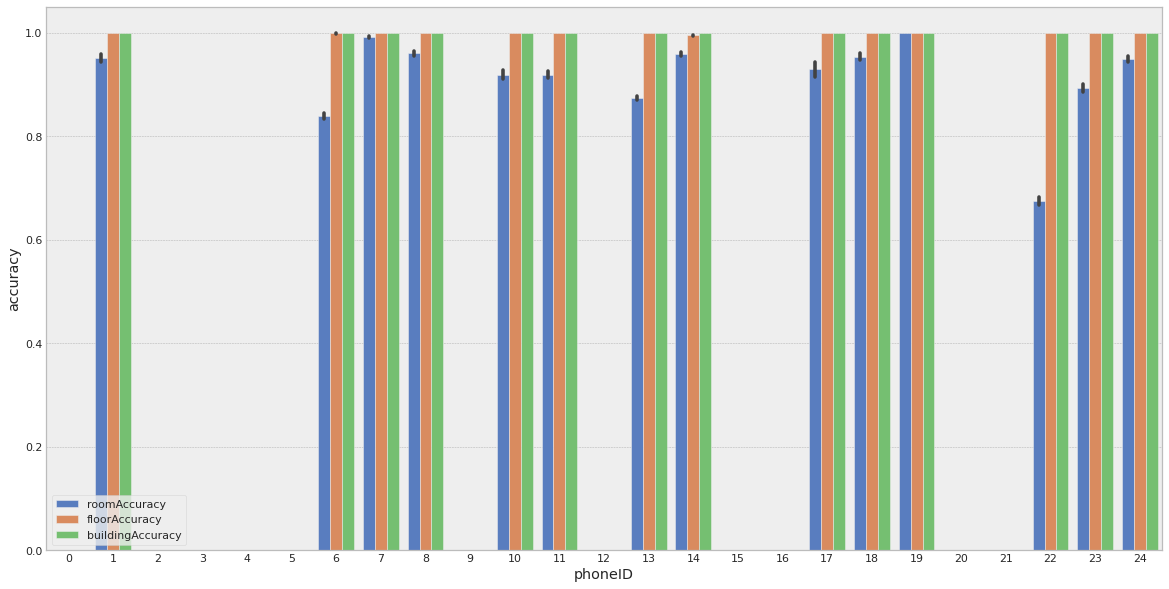

In [ ]:
resultsReshaped = np.reshape(np.array(results),(-1,3))
resultsDataframe = pd.DataFrame(resultsReshaped, columns=["phoneID","kind","accuracy"])
resultsDataframe['phoneID'] = resultsDataframe['phoneID'].astype('int32')
resultsDataframe['accuracy'] = resultsDataframe['accuracy'].astype('float')
resultsDataframe = resultsDataframe.sort_values(by=['phoneID']).reset_index().drop('index',axis=1)
plt.figure(figsize=(20, 10))
sns.set(style="whitegrid")
plt.style.use('bmh')
sns.barplot(x="phoneID", hue="kind", y="accuracy", data=resultsDataframe, palette='muted')
plt.legend(loc='best')
plt.show()



Performance evaluation inter smartphone

In [ ]:
fullDataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/trainingData.csv")
# create a label column of the format BUILDING FLOOR ROOM
fullDataset = fullDataset.assign(LABEL = 'B' + fullDataset.BUILDINGID.astype(str) + 'F' + fullDataset.FLOOR.astype(str) + 'R' + fullDataset.SPACEID.astype(str))
# drop scans with no APs detected
fullDataset = fullDataset.loc[fullDataset.iloc[:,:520].ne(100,axis=0).any(axis=1)].reset_index().drop('index',axis=1)
# drop APs never detected
fullDataset = fullDataset.iloc[:, fullDataset.iloc[:,:520].ne(100,axis=1).any(axis=0).values.tolist() + [True]*10]
# filter by the relative position (drop the scans outside the room)
fullDataset = fullDataset.loc[fullDataset['RELATIVEPOSITION']==1].reset_index().drop('index',axis=1)
# set the non-detected APs to -150 dBm
fullDataset = fullDataset.replace(to_replace=100,value=-150)
results = []
for iterationNumber in range(100):
  clear_output(wait=True) # clear output for each iteration
  dictionary = {}
  for phoneID in range(25):
    key = phoneID
    dataset = fullDataset.loc[fullDataset['PHONEID']==phoneID].reset_index().drop('index',axis=1)
    dataset = dataset.drop(['LONGITUDE','LATITUDE','USERID','PHONEID','TIMESTAMP','RELATIVEPOSITION','FLOOR','BUILDINGID','SPACEID'],axis=1)
    data = dataset.drop('LABEL',axis=1)
    labels = dataset['LABEL']
    try:
      xTrain, xTest, yTrain, yTest = train_test_split(data,labels,test_size=0.25,stratify=labels)
      xTrain = xTrain.reset_index().drop('index',axis=1)
      xTest = xTest.reset_index().drop('index',axis=1)
      yTrain = yTrain.reset_index().drop('index',axis=1)
      yTest = yTest.reset_index().drop('index',axis=1)
      value = (xTrain, xTest, yTrain, yTest)
    except:
      value = (0,0,0,0)
    dictionary[key] = value
  # training 
  # cross training
  for phoneIDTraining in range(25):
    neigh = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute', p=1, metric='minkowski')
    try:
      neigh.fit(dictionary[phoneIDTraining][0],dictionary[phoneIDTraining][2].values.ravel())
      for phoneIDValidation in range(25):
        try: 
          yPred = neigh.predict(dictionary[phoneIDValidation][1])
          accuracy = (phoneIDTraining,phoneIDValidation,accuracy_score(dictionary[phoneIDValidation][3],yPred))
          results.append(accuracy)
        except:
          pass
    except:
      pass
  # train on all, test on 1
  xTrainFull = pd.DataFrame()
  yTrainFull = pd.DataFrame()
  for phoneIDTraining in range(25):
    try:
      xTrainFull = xTrainFull.append(dictionary[phoneIDTraining][0],ignore_index=True)
      yTrainFull = yTrainFull.append(dictionary[phoneIDTraining][2],ignore_index=True)
    except:
      pass
  neigh = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute', p=1, metric='minkowski')
  neigh.fit(xTrainFull,yTrainFull.values.ravel())
  for phoneIDValidation in range(25):
    try:
      yPred = neigh.predict(dictionary[phoneIDValidation][1])
      accuracy = ("all",phoneIDValidation,accuracy_score(dictionary[phoneIDValidation][3],yPred))
      results.append(accuracy)
    except:
      pass
  # train on 1, test on all
  xTestFull = pd.DataFrame()
  yTestFull = pd.DataFrame()
  for phoneIDValidation in range(25):
    try:
      xTestFull = xTestFull.append(dictionary[phoneIDValidation][1],ignore_index=True)
      yTestFull = yTestFull.append(dictionary[phoneIDValidation][3],ignore_index=True)
    except:
      pass
  for phoneIDTraining in range(25):
    try: 
      neigh = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute', p=1, metric='minkowski')
      neigh.fit(dictionary[phoneIDTraining][0],dictionary[phoneIDTraining][2].values.ravel())
      yPred = neigh.predict(xTestFull)
      accuracy = (phoneIDTraining,"all",accuracy_score(yTestFull,yPred))
      results.append(accuracy)
    except:
      pass
  # train on all, test on all
  neigh = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute', p=1, metric='minkowski')
  neigh.fit(xTrainFull,yTrainFull.values.ravel())
  yPred = neigh.predict(xTestFull)
  accuracy = ("all","all",accuracy_score(yTestFull,yPred))
  results.append(accuracy)
  print("Progess:",np.round((iterationNumber+1)/len(range(100)) *100, 2),"%") # print loop progress

Progess: 100.0 %


22500

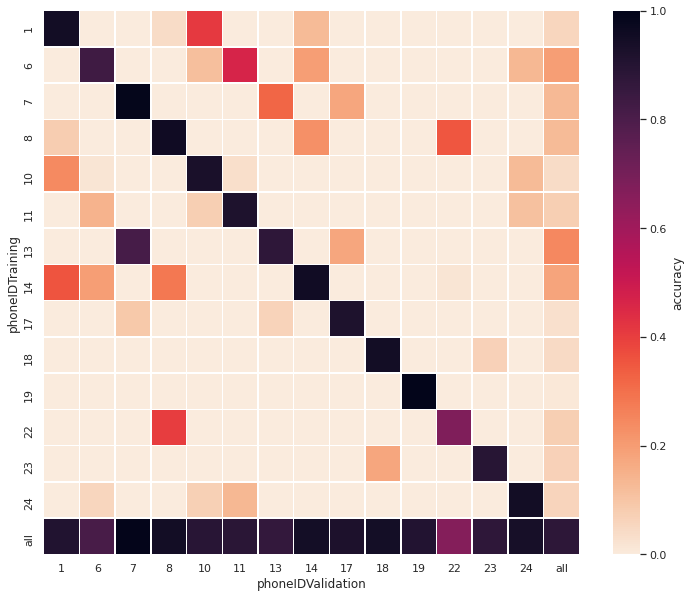

In [ ]:
table = pd.DataFrame(results).rename(columns={0: "phoneIDTraining", 1: "phoneIDValidation", 2: "accuracy"}).pivot_table(index="phoneIDTraining",columns="phoneIDValidation",values="accuracy",aggfunc='mean')
plt.figure(figsize=[12, 10])
sns.set()
ax = sns.heatmap(table, vmin=0, vmax=1, cbar_kws={'label': 'accuracy'}, cmap = sns.cm.rocket_r, linewidths=.5)

Dimesnionality Reduction on crowdfounded dataset

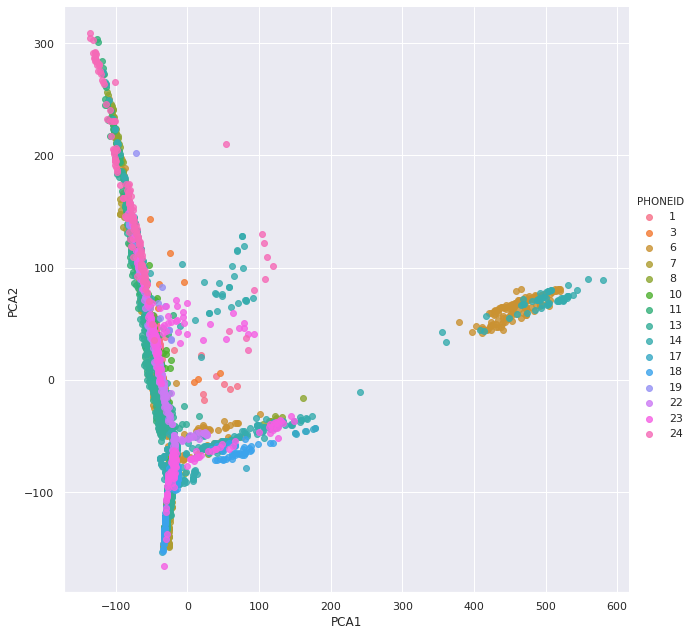

In [ ]:
# PCA
fullDataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/trainingData.csv")
# create a label column of the format BUILDING FLOOR ROOM
fullDataset = fullDataset.assign(LABEL = 'B' + fullDataset.BUILDINGID.astype(str) + 'F' + fullDataset.FLOOR.astype(str) + 'R' + fullDataset.SPACEID.astype(str))
# drop scans with no APs detected
fullDataset = fullDataset.loc[fullDataset.iloc[:,:520].ne(100,axis=0).any(axis=1)].reset_index().drop('index',axis=1)
# drop APs never detected
fullDataset = fullDataset.iloc[:, fullDataset.iloc[:,:520].ne(100,axis=1).any(axis=0).values.tolist() + [True]*10]
# filter by the relative position (drop the scans outside the room)
fullDataset = fullDataset.loc[fullDataset['RELATIVEPOSITION']==1].reset_index().drop('index',axis=1)
# set the non-detected APs to -150 dBm
fullDataset = fullDataset.replace(to_replace=100,value=-150)
# create the feature matrix
xFullDataset = fullDataset.iloc[:,:465]
# choose the model class
from sklearn.decomposition import PCA
# instantiate the model
model = PCA(n_components=2)
# fit to data
model.fit(xFullDataset)
# transform the data to two dimentions
xFullDataset_2D = model.transform(xFullDataset)
# plot the results 
fullDataset['PCA1'] = xFullDataset_2D[:,0]
fullDataset['PCA2'] = xFullDataset_2D[:,1]
sns.set()
sns.lmplot("PCA1","PCA2",hue='PHONEID', data=fullDataset,fit_reg=False, height=9)


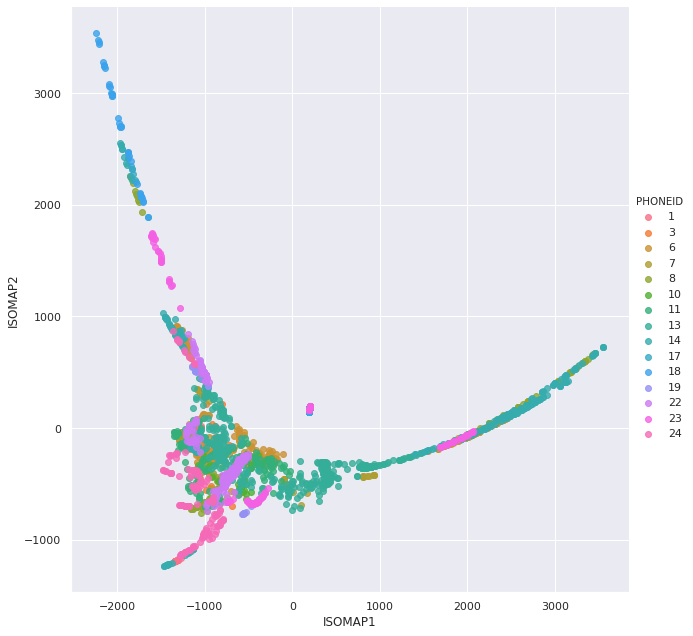

In [ ]:
# ISOMAP
from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
iso.fit(xFullDataset)
data_projected = iso.transform(xFullDataset)
fullDataset['ISOMAP1'] = data_projected[:,0]
fullDataset['ISOMAP2'] = data_projected[:,1]
sns.set()
sns.lmplot("ISOMAP1","ISOMAP2",hue='PHONEID', data=fullDataset,fit_reg=False, height=9)


Gaussian Naive Bayes Classifier (good for high dimensionality and Gaussian data)

Progess: 100.0 %


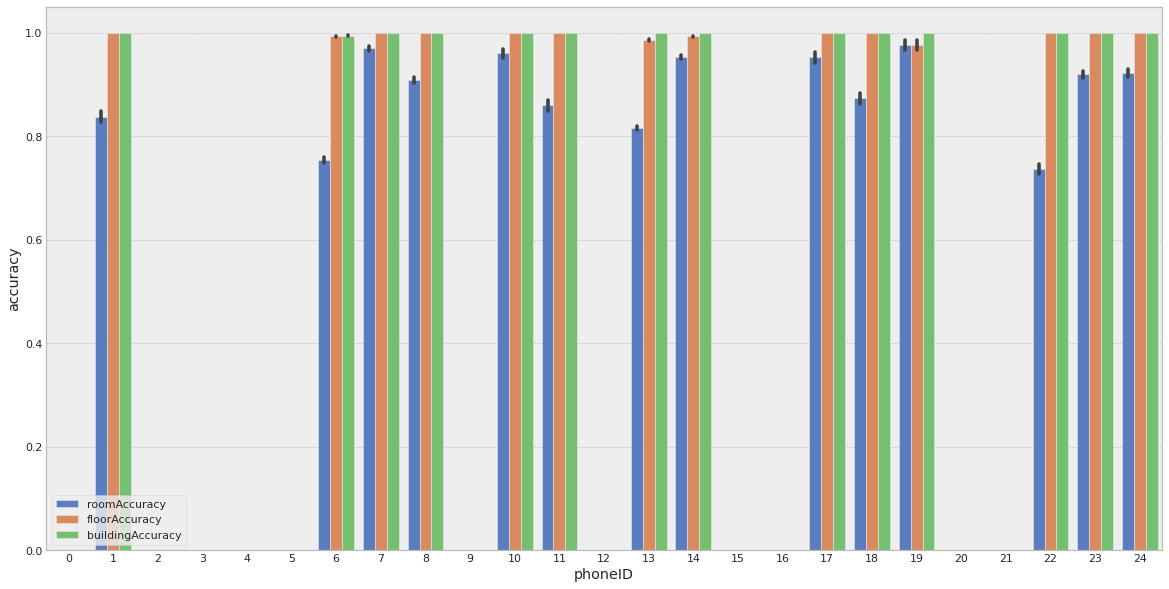

In [ ]:
from sklearn.naive_bayes import GaussianNB
fullDataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/trainingData.csv")
# create a label column of the format BUILDING FLOOR ROOM
fullDataset = fullDataset.assign(LABEL = 'B' + fullDataset.BUILDINGID.astype(str) + 'F' + fullDataset.FLOOR.astype(str) + 'R' + fullDataset.SPACEID.astype(str))
# drop scans with no APs detected
fullDataset = fullDataset.loc[fullDataset.iloc[:,:520].ne(100,axis=0).any(axis=1)].reset_index().drop('index',axis=1)
# drop APs never detected
fullDataset = fullDataset.iloc[:, fullDataset.iloc[:,:520].ne(100,axis=1).any(axis=0).values.tolist() + [True]*10]
# filter by the relative position (drop the scans outside the room)
fullDataset = fullDataset.loc[fullDataset['RELATIVEPOSITION']==1].reset_index().drop('index',axis=1)
# set the non-detected APs to -150 dBm
fullDataset = fullDataset.replace(to_replace=100,value=-150)
results = []
for iterationNumber in range(100):
  clear_output(wait=True) # clear output for each iteration
  for phoneID in range(25):
    #print(phoneID)
    # filter by the phone number
    dataset = fullDataset.loc[fullDataset['PHONEID']==phoneID]
    # drop useless columns
    dataset = dataset.drop(['LONGITUDE','LATITUDE','USERID','PHONEID','TIMESTAMP','RELATIVEPOSITION','FLOOR','BUILDINGID','SPACEID'],axis=1)
    # split the training and test set
    data = dataset.drop('LABEL',axis=1)
    labels = dataset['LABEL']
    try:
      xTrain, xTest, yTrain, yTest = train_test_split(data,labels,test_size=0.25,stratify=labels)
      # training phase
      model = GaussianNB()
      model.fit(xTrain,yTrain)
      # validation phase
      yPred = model.predict(xTest)
      # accuracy evaluation
      #print("Room accuracy:",accuracy_score(yTest,yPred))
      roomAccuracy = (phoneID, "roomAccuracy", accuracy_score(yTest,yPred))
      yTest = [yTest.reset_index().LABEL[i][:4] for i in range(yTest.shape[0])]
      yPred = [yPred[i][:4] for i in range(yPred.shape[0])]
      #print("Floor accuracy:",accuracy_score(yTest,yPred))
      floorAccuracy = (phoneID, "floorAccuracy", accuracy_score(yTest,yPred))
      yTest = [yTest[i][:2] for i in range(len(yTest))]
      yPred = [yPred[i][:2] for i in range(len(yPred))]
      #print("Building accuracy:",accuracy_score(yTest,yPred))
      buildingAccuracy = (phoneID, "buildingAccuracy", accuracy_score(yTest,yPred))
      accuracy = (roomAccuracy, floorAccuracy, buildingAccuracy)
      results.append(accuracy)
    except:
      #print("Error")
      roomAccuracy = (phoneID, "roomAccuracy", 0)
      floorAccuracy = (phoneID, "floorAccuracy", 0)
      buildingAccuracy = (phoneID, "buildingAccuracy", 0)
      accuracy = (roomAccuracy, floorAccuracy, buildingAccuracy)
      results.append(accuracy)
  print("Progess:",np.round((iterationNumber+1)/len(range(100)) *100, 2),"%") # print loop progress
# plot
resultsReshaped = np.reshape(np.array(results),(-1,3))
resultsDataframe = pd.DataFrame(resultsReshaped, columns=["phoneID","kind","accuracy"])
resultsDataframe['phoneID'] = resultsDataframe['phoneID'].astype('int32')
resultsDataframe['accuracy'] = resultsDataframe['accuracy'].astype('float')
resultsDataframe = resultsDataframe.sort_values(by=['phoneID']).reset_index().drop('index',axis=1)
plt.figure(figsize=(20, 10))
sns.set(style="whitegrid")
plt.style.use('bmh')
sns.barplot(x="phoneID", hue="kind", y="accuracy", data=resultsDataframe, palette='muted')
plt.legend(loc='best')
plt.show()

Study of the dataset

In [ ]:
fullDataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/trainingData.csv")
fullDataset.iloc[0].index[fullDataset.iloc[0].ne(100)]

Index(['WAP090', 'WAP091', 'WAP103', 'WAP104', 'WAP105', 'WAP106', 'WAP125',
       'WAP126', 'WAP166', 'WAP167', 'WAP168', 'WAP169', 'WAP171', 'WAP172',
       'WAP173', 'WAP191', 'WAP192', 'LONGITUDE', 'LATITUDE', 'FLOOR',
       'BUILDINGID', 'SPACEID', 'RELATIVEPOSITION', 'USERID', 'PHONEID',
       'TIMESTAMP'],
      dtype='object')

In [ ]:
fullDataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/trainingData.csv")
B0 = fullDataset.loc[fullDataset['BUILDINGID']==0].reset_index().drop('index',axis=1)
B1 = fullDataset.loc[fullDataset['BUILDINGID']==1].reset_index().drop('index',axis=1)
B2 = fullDataset.loc[fullDataset['BUILDINGID']==2].reset_index().drop('index',axis=1)
APsB0 = B0.iloc[:,:520].ne(100).any(axis=0).index[B0.iloc[:,:520].ne(100).any(axis=0)].values
APsB1 = B1.iloc[:,:520].ne(100).any(axis=0).index[B1.iloc[:,:520].ne(100).any(axis=0)].values
APsB2 = B2.iloc[:,:520].ne(100).any(axis=0).index[B2.iloc[:,:520].ne(100).any(axis=0)].values
APsB0B1 = np.intersect1d(APsB0,APsB1).shape[0]
APsB0notB1 = np.setdiff1d(APsB0,APsB1).shape[0]
APsB1B2 = np.intersect1d(APsB1,APsB2).shape[0]
APsB1notB2 = np.setdiff1d(APsB1,APsB2).shape[0]
APsB0B2 = np.intersect1d(APsB0,APsB2).shape[0]
APsB0notB2 = np.setdiff1d(APsB0,APsB2).shape[0]
from functools import reduce
reduce(np.intersect1d, (APsB0,APsB1,APsB2))
reduce(np.setdiff1d, (APsB0,APsB1,APsB2)).shape[0]


141 125 193


Data Cleaning

In [ ]:
def localization(dataCleaning,fillna):
  fullDataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/trainingData.csv")
  # create label
  fullDataset = fullDataset.assign(LABEL = 'B' + fullDataset.BUILDINGID.astype(str) + 'F' + fullDataset.FLOOR.astype(str) + 'R' + fullDataset.SPACEID.astype(str))
  # replace 100 with NaN
  fullDataset = fullDataset.replace(100,np.nan)
  # drop corridors
  fullDataset = fullDataset.loc[fullDataset['RELATIVEPOSITION']==1].reset_index().drop('index',axis=1)
  ## DATA CLEANING
  if dataCleaning == True:
    # drop APs never detected
    fullDataset = fullDataset.replace(100,np.nan).iloc[:,fullDataset.iloc[:,:520].replace(100,np.nan).max().notna().values.tolist() + [True]*10]
    # drop scans with no WiFi coverage
    fullDataset = fullDataset.loc[fullDataset.iloc[:,:333].max(axis=1).notna()].reset_index().drop('index',axis=1)
    # clean fingerpinting database
    X = fullDataset.iloc[:,:333]
    Y = fullDataset['LABEL']
    # apply algorithm
    xTrain, xTest, yTrain, yTest = train_test_split(X.fillna(fillna),Y,test_size=0.25,stratify=Y)
    neigh = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute', p=1, metric='minkowski')
    neigh.fit(xTrain,yTrain.values.ravel())
    yPred = neigh.predict(xTest)
    return accuracy_score(yTest,yPred)
  if dataCleaning == False:
    X = fullDataset.iloc[:,:520]
    Y = fullDataset['LABEL']
    # apply algorithm
    xTrain, xTest, yTrain, yTest = train_test_split(X.fillna(fillna),Y,test_size=0.25,stratify=Y)
    neigh = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute', p=1, metric='minkowski')
    neigh.fit(xTrain,yTrain.values.ravel())
    yPred = neigh.predict(xTest)
    return accuracy_score(yTest,yPred)

accuracyWithoutCleaning = []
accuracyWithCleaning = []
for i in range(100):
  clear_output(wait=True) # clear output for each iteration
  accuracyWithoutCleaning.append(localization(dataCleaning=False,fillna=-110))
  accuracyWithCleaning.append(localization(dataCleaning=True,fillna=-110))
  print("Progress:",i+1,"%")
print("Without data cleaning:", mean(accuracyWithoutCleaning))
print("With data cleaning:", mean(accuracyWithCleaning))

Progress: 100 %
Without data cleaning: 0.9104921968787515
With data cleaning: 0.9157920193470375


Dataset Representations

Positive Transformation

In [ ]:
def localization(transformation,fillna):
  fullDataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/trainingData.csv")
  # create label
  fullDataset = fullDataset.assign(LABEL = 'B' + fullDataset.BUILDINGID.astype(str) + 'F' + fullDataset.FLOOR.astype(str) + 'R' + fullDataset.SPACEID.astype(str))
  ## DATA CLEANING
  # replace 100 with NaN
  fullDataset = fullDataset.replace(100,np.nan)
  # drop corridors
  fullDataset = fullDataset.loc[fullDataset['RELATIVEPOSITION']==1].reset_index().drop('index',axis=1)
  # drop APs never detected
  fullDataset = fullDataset.replace(100,np.nan).iloc[:,fullDataset.iloc[:,:520].replace(100,np.nan).max().notna().values.tolist() + [True]*10]
  # drop scans with no WiFi coverage
  fullDataset = fullDataset.loc[fullDataset.iloc[:,:333].max(axis=1).notna()].reset_index().drop('index',axis=1)
  # clean fingerpinting database
  X = fullDataset.iloc[:,:333]
  Y = fullDataset['LABEL']
  if transformation == True:
    # data transformation
    XPositive = X.subtract(X.min().min()).fillna(0) # shifting the dBm values to positive interval, replacing NaN with 0
    # localization algorithm 
    xTrain, xTest, yTrain, yTest = train_test_split(XPositive,Y,test_size=0.25,stratify=Y)
    neigh = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute', p=1, metric='minkowski')
    neigh.fit(xTrain,yTrain.values.ravel())
    yPred = neigh.predict(xTest)
    return accuracy_score(yTest,yPred)
  else:
    XdBm = X.fillna(fillna)
    xTrain, xTest, yTrain, yTest = train_test_split(XdBm,Y,test_size=0.25,stratify=Y)
    neigh = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute', p=1, metric='minkowski')
    neigh.fit(xTrain,yTrain.values.ravel())
    yPred = neigh.predict(xTest)
    return accuracy_score(yTest,yPred)

accuracyWithoutPositive110 = []
accuracyWithoutPositive150 = []
accuracyWithPositive = []
for i in range(100):
  clear_output(wait=True) # clear output for each iteration
  accuracyWithoutPositive110.append(localization(transformation=False,fillna=-110))
  accuracyWithoutPositive150.append(localization(transformation=False,fillna=-150))
  accuracyWithPositive.append(localization(transformation=True,fillna=0))
  print("Progress:",i+1,"%")
print("Accuracy without transformation 110:", mean(accuracyWithoutPositive110))
print("Accuracy without transformation 150:", mean(accuracyWithoutPositive150))
print("Accuracy with transformation:", mean(accuracyWithPositive))



Progress: 100 %
Accuracy without transformation 110: 0.9160701330108827
Accuracy without transformation 150: 0.874316807738815
Accuracy with transformation: 0.9275937122128174


In [ ]:
fullDataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/trainingData.csv")
# create label
fullDataset = fullDataset.assign(LABEL = 'B' + fullDataset.BUILDINGID.astype(str) + 'F' + fullDataset.FLOOR.astype(str) + 'R' + fullDataset.SPACEID.astype(str))
## DATA CLEANING
# replace 100 with NaN
fullDataset = fullDataset.replace(100,np.nan)
# drop corridors
fullDataset = fullDataset.loc[fullDataset['RELATIVEPOSITION']==1].reset_index().drop('index',axis=1)
# drop APs never detected
fullDataset = fullDataset.replace(100,np.nan).iloc[:,fullDataset.iloc[:,:520].replace(100,np.nan).max().notna().values.tolist() + [True]*10]
# drop scans with no WiFi coverage
fullDataset = fullDataset.loc[fullDataset.iloc[:,:333].max(axis=1).notna()].reset_index().drop('index',axis=1)
# remove classes < 10 for cross-validation
classesGreater10 = Y.value_counts().reset_index()[Y.value_counts().reset_index()['LABEL'] >= 10]['index'].to_list()
fullDataset = fullDataset[fullDataset['LABEL'].isin(classesGreater10)].reset_index().drop('index',axis=1)
# clean fingerpinting database
X = fullDataset.iloc[:,:333]
Y = fullDataset['LABEL']

def sorensen(v1,v2):
  return np.sum(np.absolute(np.subtract(v1,v2)))/np.sum(np.add(v1,v2))

def localization(dataset):
  neigh = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute', p=1, metric='minkowski')
  #neigh = KNeighborsClassifier(n_neighbors=5, algorithm='brute', metric=sorensen)
  return mean(cross_val_score(neigh, dataset, Y, cv=5))

## DATA TRANSFORMATION

XdBm = X.fillna(-150) # dBm scale fillning NaN with -110 dBm
print("XdBm:",localization(XdBm))

XPositive = X.subtract(X.min().min()).fillna(0) # shifting the dBm values to positive interval, replacing NaN with 0 
print("XPositive:",localization(XPositive))

XNorm = XPositive.divide(-X.min().min()) # normalizing the positive values in the interval [0,1)
print("XNorm:",localization(XNorm))

XmW = 10**((X)/10.)
XmW = XmW.fillna(0) # Watts scale
print("XmW:",localization(XmW))

quadratic = 0.006 * XPositive**2
print("Quadratic:",localization(quadratic))

exponential = (np.exp((XPositive)/24.))/(np.exp((-X.min().min())/24.))
print("Exponential:",localization(exponential))

powed = (np.power(XPositive,np.exp(1)))/(np.power(-X.min().min(),np.exp(1)))
print("Powed:",localization(powed))

from sklearn.preprocessing import MaxAbsScaler
XPositiveScaled = MaxAbsScaler().fit_transform(XPositive)
print("Scaled:",localization(XPositiveScaled))
from sklearn.preprocessing import Normalizer
XPositiveNormalized = Normalizer().fit_transform(XPositive)
print("Normalized:",localization(XPositiveNormalized))


XdBm: 0.8558396474025652
XPositive: 0.9134447580844847
XNorm: 0.913759718714406
XmW: 0.7132526122913881
Quadratic: 0.908727281731293
Exponential: 0.9165918882781162
Powed: 0.8813425444460952
Scaled: 0.9077774476303669
Normalized: 0.8807126231862527


In [ ]:
XPositive.iloc[3,10]
X.min().min()
powed.iloc[3,10]

0.006504233450464931

PCA as Noise Filtering

In [ ]:
from sklearn.decomposition import PCA
fullDataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/trainingData.csv")
# create label
fullDataset = fullDataset.assign(LABEL = 'B' + fullDataset.BUILDINGID.astype(str) + 'F' + fullDataset.FLOOR.astype(str) + 'R' + fullDataset.SPACEID.astype(str))
## DATA CLEANING
# replace 100 with NaN
fullDataset = fullDataset.replace(100,np.nan)
# drop corridors
fullDataset = fullDataset.loc[fullDataset['RELATIVEPOSITION']==1].reset_index().drop('index',axis=1)
# drop APs never detected
fullDataset = fullDataset.replace(100,np.nan).iloc[:,fullDataset.iloc[:,:520].replace(100,np.nan).max().notna().values.tolist() + [True]*10]
# drop scans with no WiFi coverage
fullDataset = fullDataset.loc[fullDataset.iloc[:,:333].max(axis=1).notna()].reset_index().drop('index',axis=1)
# remove classes < 10 for cross-validation
classesGreater10 = Y.value_counts().reset_index()[Y.value_counts().reset_index()['LABEL'] >= 10]['index'].to_list()
fullDataset = fullDataset[fullDataset['LABEL'].isin(classesGreater10)].reset_index().drop('index',axis=1)
# clean fingerpinting database
X = fullDataset.iloc[:,:333]
Y = fullDataset['LABEL']
XdBm = X.replace(np.nan, 0, regex=True)
XPositive = X.subtract(X.min().min()).fillna(0)
# Noise filtering
pca = PCA(0.98).fit(XPositive)
pca.n_components_
pcaComponents = pca.transform(XPositive)
XFiltered = pca.inverse_transform(pcaComponents)
XFiltered = pd.DataFrame(XFiltered)
XFiltered


def localization(dataset):
  neigh = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute', p=1, metric='minkowski')
  return mean(cross_val_score(neigh, dataset, Y, cv=5))
print("XPositive:",localization(XPositive))
print("XFiltered:",localization(XFiltered))


XPositive: 0.9134447580844847
XFiltered: 0.9096627544198485


In [ ]:
# pca = PCA(0.90).fit(XPositive)
# print(pca.n_components_)
# pcaComponents = pca.transform(XPositive)
# XFiltered = pca.inverse_transform(pcaComponents)
# pd.DataFrame(XFiltered).round()

Sorensen Distance

In [ ]:
fullDataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/trainingData.csv")
# create label
fullDataset = fullDataset.assign(LABEL = 'B' + fullDataset.BUILDINGID.astype(str) + 'F' + fullDataset.FLOOR.astype(str) + 'R' + fullDataset.SPACEID.astype(str))
## DATA CLEANING
# replace 100 with NaN
fullDataset = fullDataset.replace(100,np.nan)
# drop corridors
fullDataset = fullDataset.loc[fullDataset['RELATIVEPOSITION']==1].reset_index().drop('index',axis=1)
# drop APs never detected
fullDataset = fullDataset.replace(100,np.nan).iloc[:,fullDataset.iloc[:,:520].replace(100,np.nan).max().notna().values.tolist() + [True]*10]
# drop scans with no WiFi coverage
fullDataset = fullDataset.loc[fullDataset.iloc[:,:333].max(axis=1).notna()].reset_index().drop('index',axis=1)
# remove classes < 10 for cross-validation
classesGreater10 = Y.value_counts().reset_index()[Y.value_counts().reset_index()['LABEL'] >= 10]['index'].to_list()
fullDataset = fullDataset[fullDataset['LABEL'].isin(classesGreater10)].reset_index().drop('index',axis=1)
# clean fingerpinting database
X = fullDataset.iloc[:,:333]
XPositive = X.subtract(X.min().min()).fillna(0)
Y = fullDataset['LABEL']
def sorensen(v1,v2):
  return np.sum(np.absolute(np.subtract(v1,v2)))/np.sum(np.add(v1,v2))
def knnAlgo(metric):
  if metric == 'sorensen':
    neigh = KNeighborsClassifier(n_neighbors=5, algorithm='brute', metric=sorensen)
    return cross_val_score(neigh, XPositive, Y, cv=5)
  if metric == 'minkowski':
    neigh = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute', p=1, metric='minkowski')
    return cross_val_score(neigh, XPositive, Y, cv=5)

print("Minkowski:", mean(knnAlgo('minkowski')))
print("Sorensen:", mean(knnAlgo('sorensen')))

Minkowski: 0.9134447580844847
Sorensen: 0.9200524934383202


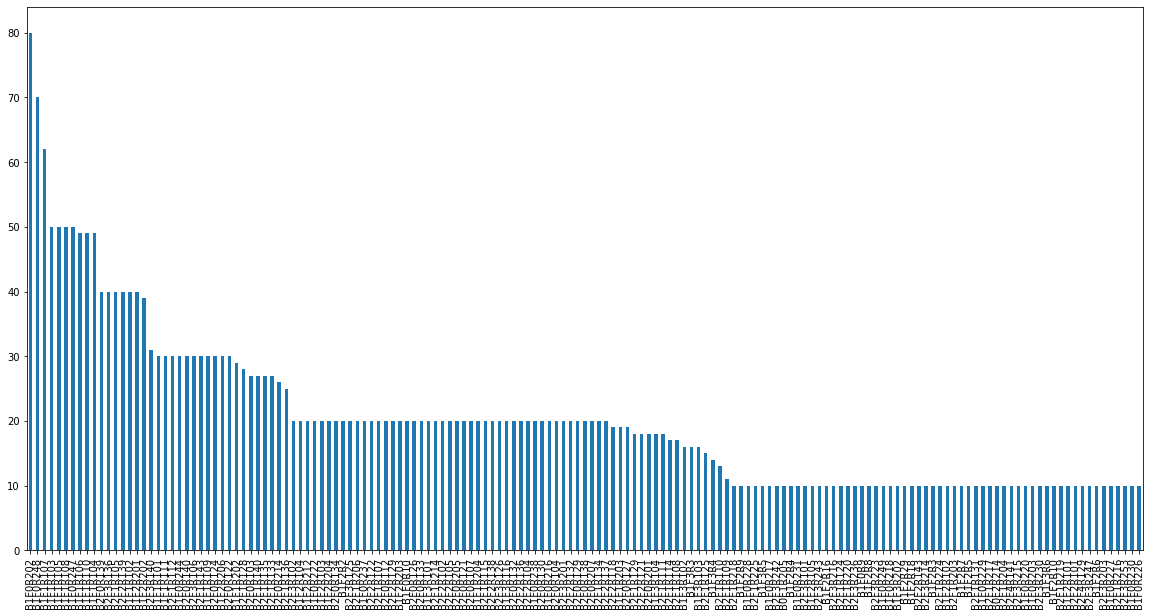

In [ ]:
plt.figure(figsize=(20, 10))
Y.value_counts().plot(kind='bar')

In [ ]:
#FAMILY 1
def manhattan(v1,v2):
  return np.sum(np.fabs(np.subtract(v1,v2)))
def euclidean(v1,v2):
  return np.sqrt(np.sum(np.square(np.fabs(np.subtract(v1,v2)))))
def chebyshev(v1,v2):
  return np.max(np.fabs(np.subtract(v1,v2)))
#FAMILY 2
def sorensen(v1,v2):
  return np.sum(np.absolute(np.subtract(v1,v2)))/np.sum(np.add(v1,v2))
def gower(v1,v2):
  return (np.sum(np.fabs(np.subtract(v1,v2))))/len(v1)
def soergel(v1,v2):
  return (np.sum(np.fabs(np.subtract(v1,v2))))/(np.sum(np.maximum(v1,v2)))
def kulczynski(v1,v2):
  return (np.sum(np.fabs(np.subtract(v1,v2))))/(np.sum(np.minimum(v1,v2)))
def canberra(v1,v2):
  a = np.array(v1, dtype=float)
  b = np.array(v2, dtype=float)
  return np.sum(np.divide((np.fabs(np.subtract(a,b))),(np.add(np.absolute(a),np.absolute(b))), out=np.zeros_like(a), where=b!=0))
def lorentzian(v1,v2):
  return np.sum(np.log(1+(np.fabs(np.subtract(v1,v2)))))
kulczynski([0,3,5],(0,1,3))

1.0

In [ ]:
v1 = [0,3,5]
v2 = [0,1,0]
a = np.array(v1, dtype=float)
b = np.array(v2, dtype=float)
np.divide(a, b, out=np.zeros_like(a), where=b!=0)

array([0., 3., 0.])

In [ ]:
#FAMILY 1
def manhattan(v1,v2):
  return np.sum(np.fabs(np.subtract(v1,v2)))
def euclidean(v1,v2):
  return np.sqrt(np.sum(np.square(np.fabs(np.subtract(v1,v2)))))
def chebyshev(v1,v2):
  return np.max(np.fabs(np.subtract(v1,v2)))
#FAMILY 2
def sorensen(v1,v2):
  return np.sum(np.absolute(np.subtract(v1,v2)))/np.sum(np.add(v1,v2))
def gower(v1,v2):
  return (np.sum(np.fabs(np.subtract(v1,v2))))/len(v1)
def soergel(v1,v2):
  return (np.sum(np.fabs(np.subtract(v1,v2))))/(np.sum(np.maximum(v1,v2)))
def kulczynski(v1,v2):
  return (np.sum(np.fabs(np.subtract(v1,v2))))/(np.sum(np.minimum(v1,v2)))
def canberra(v1,v2):
  a = np.array(v1, dtype=float)
  b = np.array(v2, dtype=float)
  return np.sum(np.divide((np.fabs(np.subtract(a,b))),(np.add(np.absolute(a),np.absolute(b))), out=np.zeros_like(a), where=b!=0))
def lorentzian(v1,v2):
  return np.sum(np.log(1+(np.fabs(np.subtract(v1,v2)))))
lorentzian([1,3,5],(0,1,3))

fullDataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/trainingData.csv")
# create label
fullDataset = fullDataset.assign(LABEL = 'B' + fullDataset.BUILDINGID.astype(str) + 'F' + fullDataset.FLOOR.astype(str) + 'R' + fullDataset.SPACEID.astype(str))
## DATA CLEANING
# replace 100 with NaN
fullDataset = fullDataset.replace(100,np.nan)
# drop corridors
fullDataset = fullDataset.loc[fullDataset['RELATIVEPOSITION']==1].reset_index().drop('index',axis=1)
# drop APs never detected
fullDataset = fullDataset.replace(100,np.nan).iloc[:,fullDataset.iloc[:,:520].replace(100,np.nan).max().notna().values.tolist() + [True]*10]
# drop scans with no WiFi coverage
fullDataset = fullDataset.loc[fullDataset.iloc[:,:333].max(axis=1).notna()].reset_index().drop('index',axis=1)
# remove classes < 10 for cross-validation
classesGreater10 = Y.value_counts().reset_index()[Y.value_counts().reset_index()['LABEL'] >= 10]['index'].to_list()
fullDataset = fullDataset[fullDataset['LABEL'].isin(classesGreater10)].reset_index().drop('index',axis=1)
# clean fingerpinting database
X = fullDataset.iloc[:,:333]
XPositive = X.subtract(X.min().min()).fillna(0)
Y = fullDataset['LABEL']
def localization(metric):
  neigh = KNeighborsClassifier(n_neighbors=5, algorithm='brute', metric=metric)
  return mean(cross_val_score(neigh, XPositive, Y, cv=5))

print("Manhattan:", localization(manhattan))
print("Euclidean:", localization(euclidean))
print("Chebyshev:", localization(chebyshev))
print("Sorensen:", localization(sorensen))
print("Gower:", localization(gower))
print("Soergel:", localization(soergel))
print("Kulczynski:", localization(kulczynski))
print("Canberra:", localization(canberra))
print("Lorentzian:", localization(lorentzian))




Manhattan: 0.9134447580844847
Euclidean: 0.8970777001931363
Chebyshev: 0.7453518546030803
Sorensen: 0.9200524934383202
Gower: 0.9134447580844847
Soergel: 0.9200524934383202


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


Kulczynski: 0.9200524934383202
Canberra: 0.23291487149012033
Lorentzian: 0.895817362452335


How to replace missing values?

<function matplotlib.pyplot.show>

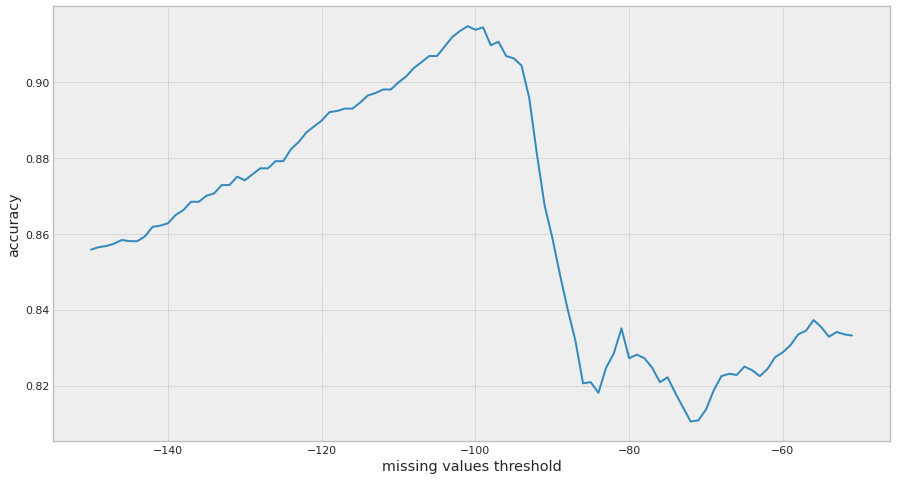

In [ ]:
fullDataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/trainingData.csv")
# create label
fullDataset = fullDataset.assign(LABEL = 'B' + fullDataset.BUILDINGID.astype(str) + 'F' + fullDataset.FLOOR.astype(str) + 'R' + fullDataset.SPACEID.astype(str))
## DATA CLEANING
# replace 100 with NaN
fullDataset = fullDataset.replace(100,np.nan)
# drop corridors
fullDataset = fullDataset.loc[fullDataset['RELATIVEPOSITION']==1].reset_index().drop('index',axis=1)
# drop APs never detected
fullDataset = fullDataset.replace(100,np.nan).iloc[:,fullDataset.iloc[:,:520].replace(100,np.nan).max().notna().values.tolist() + [True]*10]
# drop scans with no WiFi coverage
fullDataset = fullDataset.loc[fullDataset.iloc[:,:333].max(axis=1).notna()].reset_index().drop('index',axis=1)
# remove classes < 10 for cross-validation
Y = fullDataset['LABEL']
classesGreater10 = Y.value_counts().reset_index()[Y.value_counts().reset_index()['LABEL'] >= 10]['index'].to_list()
fullDataset = fullDataset[fullDataset['LABEL'].isin(classesGreater10)].reset_index().drop('index',axis=1)
# clean fingerpinting database
X = fullDataset.iloc[:,:333]
# fill NaN with value
xValues = []
accuracy = []
for i in range(-150,-50,1):
  XFilled = X.fillna(i)
  Y = fullDataset['LABEL']
  neigh = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute', p=1, metric='minkowski')
  xValues.append(i)
  accuracy.append(mean(cross_val_score(neigh, XFilled, Y, cv=5)))
plt.figure(figsize=[15, 8])
sns.set(style="whitegrid")
plt.style.use('bmh')
plt.plot(xValues,accuracy)
plt.grid(True)
plt.xlabel("missing values threshold")
plt.ylabel("accuracy")
plt.show

Weighted Euclidean Distance

In [ ]:
def manhattan(v1,v2):
  return np.sum(np.fabs(np.subtract(v1,v2)))
def euclidean(v1,v2):
  return np.sqrt(np.sum(np.square(np.fabs(np.subtract(v1,v2)))))
def weightedEuclidean(v1,v2):
  v1 = np.array(v1)
  v2 = np.array(v2)
  mrss = 0.5 * np.add(v1,v2)
  weight = np.divide(np.square(mrss),np.sum(np.square(mrss)))
  WED = np.sqrt(np.sum(weight * np.square(np.subtract(v1,v2))))
  return WED

fullDataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/trainingData.csv")
# create label
fullDataset = fullDataset.assign(LABEL = 'B' + fullDataset.BUILDINGID.astype(str) + 'F' + fullDataset.FLOOR.astype(str) + 'R' + fullDataset.SPACEID.astype(str))
## DATA CLEANING
# replace 100 with NaN
fullDataset = fullDataset.replace(100,np.nan)
# drop corridors
fullDataset = fullDataset.loc[fullDataset['RELATIVEPOSITION']==1].reset_index().drop('index',axis=1)
# drop APs never detected
fullDataset = fullDataset.replace(100,np.nan).iloc[:,fullDataset.iloc[:,:520].replace(100,np.nan).max().notna().values.tolist() + [True]*10]
# drop scans with no WiFi coverage
fullDataset = fullDataset.loc[fullDataset.iloc[:,:333].max(axis=1).notna()].reset_index().drop('index',axis=1)
# remove classes < 10 for cross-validation
Y = fullDataset['LABEL']
classesGreater10 = Y.value_counts().reset_index()[Y.value_counts().reset_index()['LABEL'] >= 10]['index'].to_list()
fullDataset = fullDataset[fullDataset['LABEL'].isin(classesGreater10)].reset_index().drop('index',axis=1)
# clean fingerpinting database
X = fullDataset.iloc[:,:333]
XPositive = X.subtract(X.min().min()).fillna(0)
Y = fullDataset['LABEL']
def localization(metric):
  neigh = KNeighborsClassifier(n_neighbors=5, algorithm='brute', metric=metric)
  return mean(cross_val_score(neigh, XPositive, Y, cv=5))

print("Manhattan:", localization(manhattan))
print("Euclidean:", localization(euclidean))
print("Weighted Euclidean", localization(weightedEuclidean))

Manhattan: 0.9134447580844847
Euclidean: 0.8970777001931363
Weighted Euclidean 0.8936161045906997


Improved Wi-Fi RSSI Measurement for Indoor Localization

In [ ]:
fullDataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/measurements/UJIIndoorLoc Data Set/trainingData.csv")
# create label
fullDataset = fullDataset.assign(LABEL = 'B' + fullDataset.BUILDINGID.astype(str) + 'F' + fullDataset.FLOOR.astype(str) + 'R' + fullDataset.SPACEID.astype(str))
## DATA CLEANING
# replace 100 with NaN
fullDataset = fullDataset.replace(100,np.nan)
# drop corridors
fullDataset = fullDataset.loc[fullDataset['RELATIVEPOSITION']==1].reset_index().drop('index',axis=1)
# drop APs never detected
fullDataset = fullDataset.replace(100,np.nan).iloc[:,fullDataset.iloc[:,:520].replace(100,np.nan).max().notna().values.tolist() + [True]*10]
# drop scans with no WiFi coverage
fullDataset = fullDataset.loc[fullDataset.iloc[:,:333].max(axis=1).notna()].reset_index().drop('index',axis=1)
# remove classes < 10 for cross-validation
Y = fullDataset['LABEL']
classesGreater10 = Y.value_counts().reset_index()[Y.value_counts().reset_index()['LABEL'] >= 10]['index'].to_list()
fullDataset = fullDataset[fullDataset['LABEL'].isin(classesGreater10)].reset_index().drop('index',axis=1)
# paper
room = fullDataset[fullDataset['LABEL'].eq('B1F0R202')].reset_index().drop('index',axis=1).fillna(-150)
result = []
for M in range(5,41):
  average = []
  for i in room.index:
    average.append(room.iloc[i,:333].sort_values(ascending=False).head(M).mean())
  rssi = average
  S = []
  for i in range(2,len(rssi)-1):
    S.append(np.sqrt(np.square(rssi[i] * (rssi[i-1] + rssi[i] + rssi[i+1]) / 3)))
  result.append([M, sum(S)])
result

[[5, 139619.14666666667],
 [6, 141837.24074074076],
 [7, 144584.27210884355],
 [8, 147345.4166666667],
 [9, 150228.3127572017],
 [10, 153255.03666666674],
 [11, 156093.73002754827],
 [12, 158835.5833333333],
 [13, 161565.37080867848],
 [14, 164311.12074829932],
 [15, 167068.8859259259],
 [16, 170366.6419270833],
 [17, 173914.40945790082],
 [18, 177928.54115226335],
 [19, 185071.81532779319],
 [20, 192035.0516666666],
 [21, 198864.1874527589],
 [22, 205699.21969696973],
 [23, 212295.91745431646],
 [24, 218700.18229166677],
 [25, 224850.04693333336],
 [26, 231086.3096646942],
 [27, 237513.54869684487],
 [28, 243841.4974489796],
 [29, 250103.22552516838],
 [30, 256634.21259259255],
 [31, 263169.23343739164],
 [32, 270078.16731770826],
 [33, 278095.60881542705],
 [34, 288523.01787773933],
 [35, 301160.82857142854],
 [36, 318097.49099794246],
 [37, 336725.3391770149],
 [38, 357350.9979224376],
 [39, 378598.20556651324],
 [40, 399780.11395833315]]

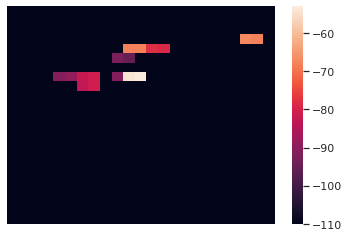

In [ ]:
x = trainingData.iloc[0,:520].fillna(-110).values
x.resize(23*23)
x = x.reshape(23,23)
x = np.where(x==0, -110, x)
import seaborn as sns; sns.set()
ax = sns.heatmap(x,xticklabels=False,yticklabels=False)


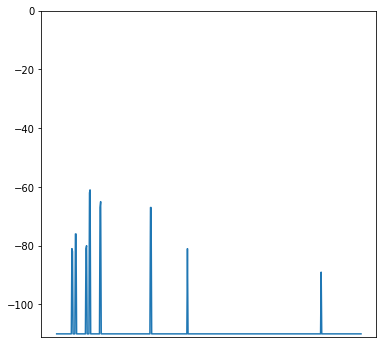

In [ ]:
trainingData = pd.read_csv(zipFile.open('UJIndoorLoc/trainingData.csv'))
trainingData = trainingData.assign(LABEL = 'B' + trainingData.BUILDINGID.astype(str) + 'F' + trainingData.FLOOR.astype(str))
trainingData.replace(to_replace=100, value=-110, inplace=True)
trainingData = trainingData[trainingData.LABEL == 'B0F0'].reset_index().drop('index',axis=1)
plt.figure(figsize=[6, 6])
plt.plot(trainingData.iloc[8,:520])
# plt.xlabel("missing values threshold")
# plt.ylabel("accuracy")
plt.xticks(ticks=None)
plt.ylim(bottom=-111,top=0)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.show()


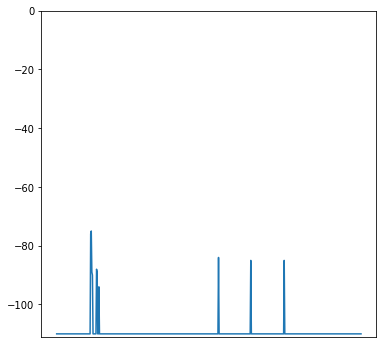

In [ ]:
trainingData = pd.read_csv(zipFile.open('UJIndoorLoc/trainingData.csv'))
trainingData = trainingData.assign(LABEL = 'B' + trainingData.BUILDINGID.astype(str) + 'F' + trainingData.FLOOR.astype(str))
trainingData.replace(to_replace=100, value=-110, inplace=True)
trainingData = trainingData[trainingData.LABEL == 'B2F0'].reset_index().drop('index',axis=1)
plt.figure(figsize=[6, 6])
plt.plot(trainingData.iloc[0,:520])
# plt.xlabel("missing values threshold")
# plt.ylabel("accuracy")
plt.xticks(ticks=None)
plt.ylim(bottom=-111,top=0)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.show()


Training, Validation and Test data

In [ ]:
features = np.asarray(trainingData.iloc[:,0:520])
# replace NaN with -110 dBm
features[features == 100] = -110
# feature normalization
features = (features - features.mean()) / features.var()

labels = np.asarray(trainingData["BUILDINGID"].map(str) + trainingData["FLOOR"].map(str))
# convert categorical variable into dummy/indicator variables
labels = np.asarray(pd.get_dummies(labels))

# training and validation set
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(features, labels, test_size=0.3, random_state = 0, stratify=labels)

# test set

test_features = np.asarray(validationData.iloc[:,0:520])
test_features[test_features == 100] = -110
test_features = (test_features - test_features.mean()) / test_features.var()

test_labels = np.asarray(validationData["BUILDINGID"].map(str) + validationData["FLOOR"].map(str))
test_labels = np.asarray(pd.get_dummies(test_labels))

In [ ]:
train_x.shape[0]
val_x.shape[0]
test_features.shape[0]

data = {'dataset':  ['training', 'validation', 'test'],
        '# samples': [train_x.shape[0], val_x.shape[0], test_features.shape[0]]
        }

df = pd.DataFrame (data, columns = ['dataset','# samples'])
df

,dataset,# samples
0,training,13955
1,validation,5982
2,test,1111


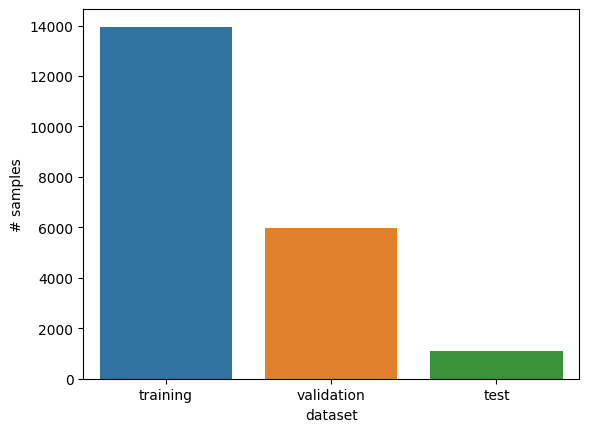

In [ ]:
import seaborn as sns
plt.style.use('default')
ax = sns.barplot(x="dataset", y="# samples", data=df)
